# Bias Detection & Data Explainability with Amazon SageMaker Clarify

## Introduction
Bias can be present in a large number of datasets and needs to subject to inspection prior to model training. As an example, insights on biased data may lead to data balancing to avoid having biased models.

Note that bias detection can be run at pre-training or at post-training stage. The latter needs a model configuration, in order to detect bias in the model's predictions. Data Explainability 

In addition to bias detection, data may contain uninformative features, which will definitely be useless when fed to a model. The objective being to clean the data for Machine Learning, it is critical to detect unnecessary features. **Data Explainability** can be run prior to training in order to detect such features. It involves techniques like *Partial Dependence* and *SHAP*, which also need a model configuration, as they are computed on top of predictions.

### Table of Contents

- [1. Analyze the dataset](#c1w2-1.)
  - [1.1. Create a pandas data frame from the CSV file](#c1w2-1.1.)
  - [1.2. Upload the dataset to S3 bucket](#c1w2-1.2.)
- [2. Analyze class imbalance on the dataset with Amazon SageMaker Clarify](#c1w2-2.)
  - [2.1. Configure a `DataConfig`](#c1w2-2.1.)
    - [Exercise 1](#c1w2-ex-1)
  - [2.2. Configure `BiasConfig`](#c1w2-2.2.)
  - [2.3. Configure Amazon SageMaker Clarify as a processing job](#c1w2-2.3.)
  - [2.4. Run the Amazon SageMaker Clarify processing job](#c1w2-2.4.)
    - [Exercise 2](#c1w2-ex-2)
  - [2.5. Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset](#c1w2-2.5.)
  - [2.6. Analyze unbalanced bias report](#c1w2-2.6.)
- [3. Balance the dataset by `product_category` and `sentiment`](#c1w2-3.)
- [4. Analyze bias on balanced dataset with Amazon SageMaker Clarify](#c1w2-4.)
  - [4.1. Configure a `DataConfig`](#c1w2-4.1.)
    - [Exercise 3](#c1w2-ex-3)
  - [4.2. Configure `BiasConfig`](#c1w2-4.2.)
  - [4.3. Configure SageMaker Clarify as a processing job](#c1w2-4.3.)
  - [4.4. Run the Amazon SageMaker Clarify processing job](#c1w2-4.4.)
    - [Exercise 4](#c1w2-ex-4)
  - [4.5. Run and review the Clarify processing job on the balanced dataset](#c1w2-4.5.)
  - [4.6. Analyze balanced bias report](#c1w2-4.6.)

In [2]:
import os
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


# 1. Import & Analyze the dataset
The problem to solve is about detecting bank customers who are more likely to churn, over two months. 

## 1.1 Import & reshape data
First import the dataset and perform data visualization to identify potential bias in the data. 



In [3]:
!aws s3 cp s3://$bucket/data/raw/BankChurners.csv ./Data Acquisition & Registry/data/BankChurners.csv


/bin/bash: line 1: Registry/data/BankChurners.csv: No such file or directory


In [63]:
!ls

BiasDetection_FeatureImportance.ipynb  README.md  data


In [74]:
local_data_path = './data/BankChurners.csv'

# Import data
data = pd.read_csv(local_data_path)
cols = list(data.columns)
data.rename(
    columns ={'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1':'churn_mon1',
              'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2':'churn_mon2'},
    inplace = True
)


# Reshape data for bias detection & training
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == 'object':
            data_frame[label] = data_frame[label].astype("str").astype("string")
    return data_frame


data = pd.concat((data['churn_mon1'], data.drop(columns = ['churn_mon1', 'churn_mon2'])), axis=1)
data = cast_object_to_string(data)
display(data.info())


# Save data for bias detection
data.to_csv('./data/BiasDetection/BankChurners.csv', index=False, header=True)


# Save data for training
data.drop(columns = ['CLIENTNUM']).to_csv('./data/XgboostTraining/BankChurners.csv', index=False, header=False)


# Target & values
target = list(data.columns)[:1]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   churn_mon1                10127 non-null  int64  
 1   CLIENTNUM                 10127 non-null  int64  
 2   Attrition_Flag            10127 non-null  string 
 3   Customer_Age              10127 non-null  int64  
 4   Gender                    10127 non-null  string 
 5   Dependent_count           10127 non-null  int64  
 6   Education_Level           10127 non-null  string 
 7   Marital_Status            10127 non-null  string 
 8   Income_Category           10127 non-null  string 
 9   Card_Category             10127 non-null  string 
 10  Months_on_book            10127 non-null  int64  
 11  Total_Relationship_Count  10127 non-null  int64  
 12  Months_Inactive_12_mon    10127 non-null  int64  
 13  Contacts_Count_12_mon     10127 non-null  int64  
 14  Credit

None

Upload transformed data to S3 Bucket & Review the [**Bias Detection data folder**](https://s3.console.aws.amazon.com/s3/buckets/sagemaker-eu-west-3-668303144976?region=eu-west-3&prefix=data/transformed/&showversions=false).

In [75]:
!aws s3 cp ./data/BiasDetection/BankChurners.csv s3://$bucket/data/transformed/BankChurners.csv


upload: data/BiasDetection/BankChurners.csv to s3://sagemaker-eu-west-3-668303144976/data/transformed/BankChurners.csv


Upload transformed data to S3 Bucket & Review the [**Xgboost Training data folder**](https://s3.console.aws.amazon.com/s3/buckets/sagemaker-eu-west-3-668303144976?region=eu-west-3&prefix=data/xgboost-training/&showversions=false).

In [76]:
!aws s3 cp ./data/XgboostTraining/BankChurners.csv s3://$bucket/data/xgboost-training/BankChurners.csv


upload: data/XgboostTraining/BankChurners.csv to s3://sagemaker-eu-west-3-668303144976/data/xgboost-training/BankChurners.csv


In [70]:
from IPython.display import display, HTML

display(HTML('<b>Review <a href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-668303144976?prefix=data/&region={}">Data Folder</a>.</b>'.format(region, region)))

## 1.2 Investigate bias with data visualiztion

This section is about investigating two main imbalances in the dataset, through the following metrics
1. **Class Imbalance (CI):** to measure the imbalance in the number of reviews between different facet values.
2. **Difference in Proportion of Labels (DPL):** to measure the imbalance of positive/negative labels between different facet values.

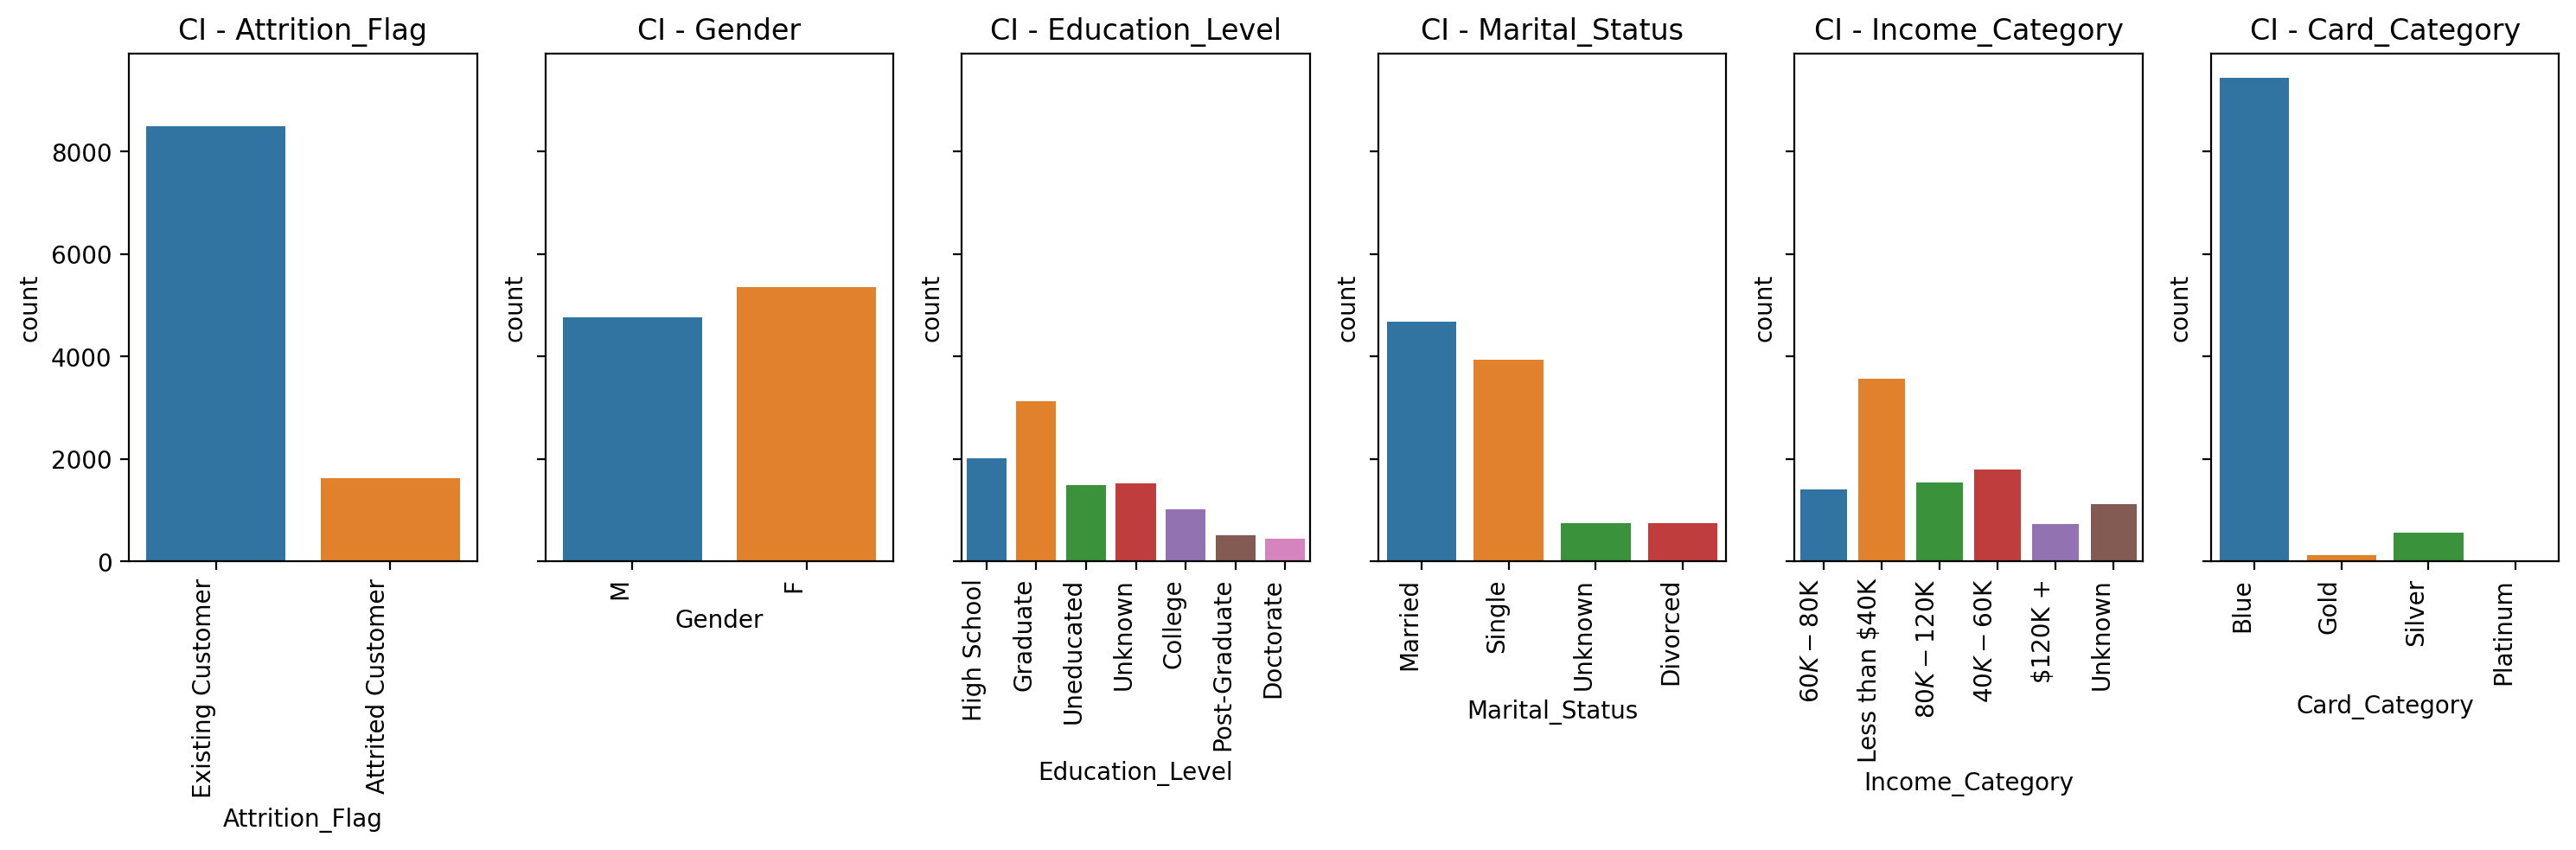

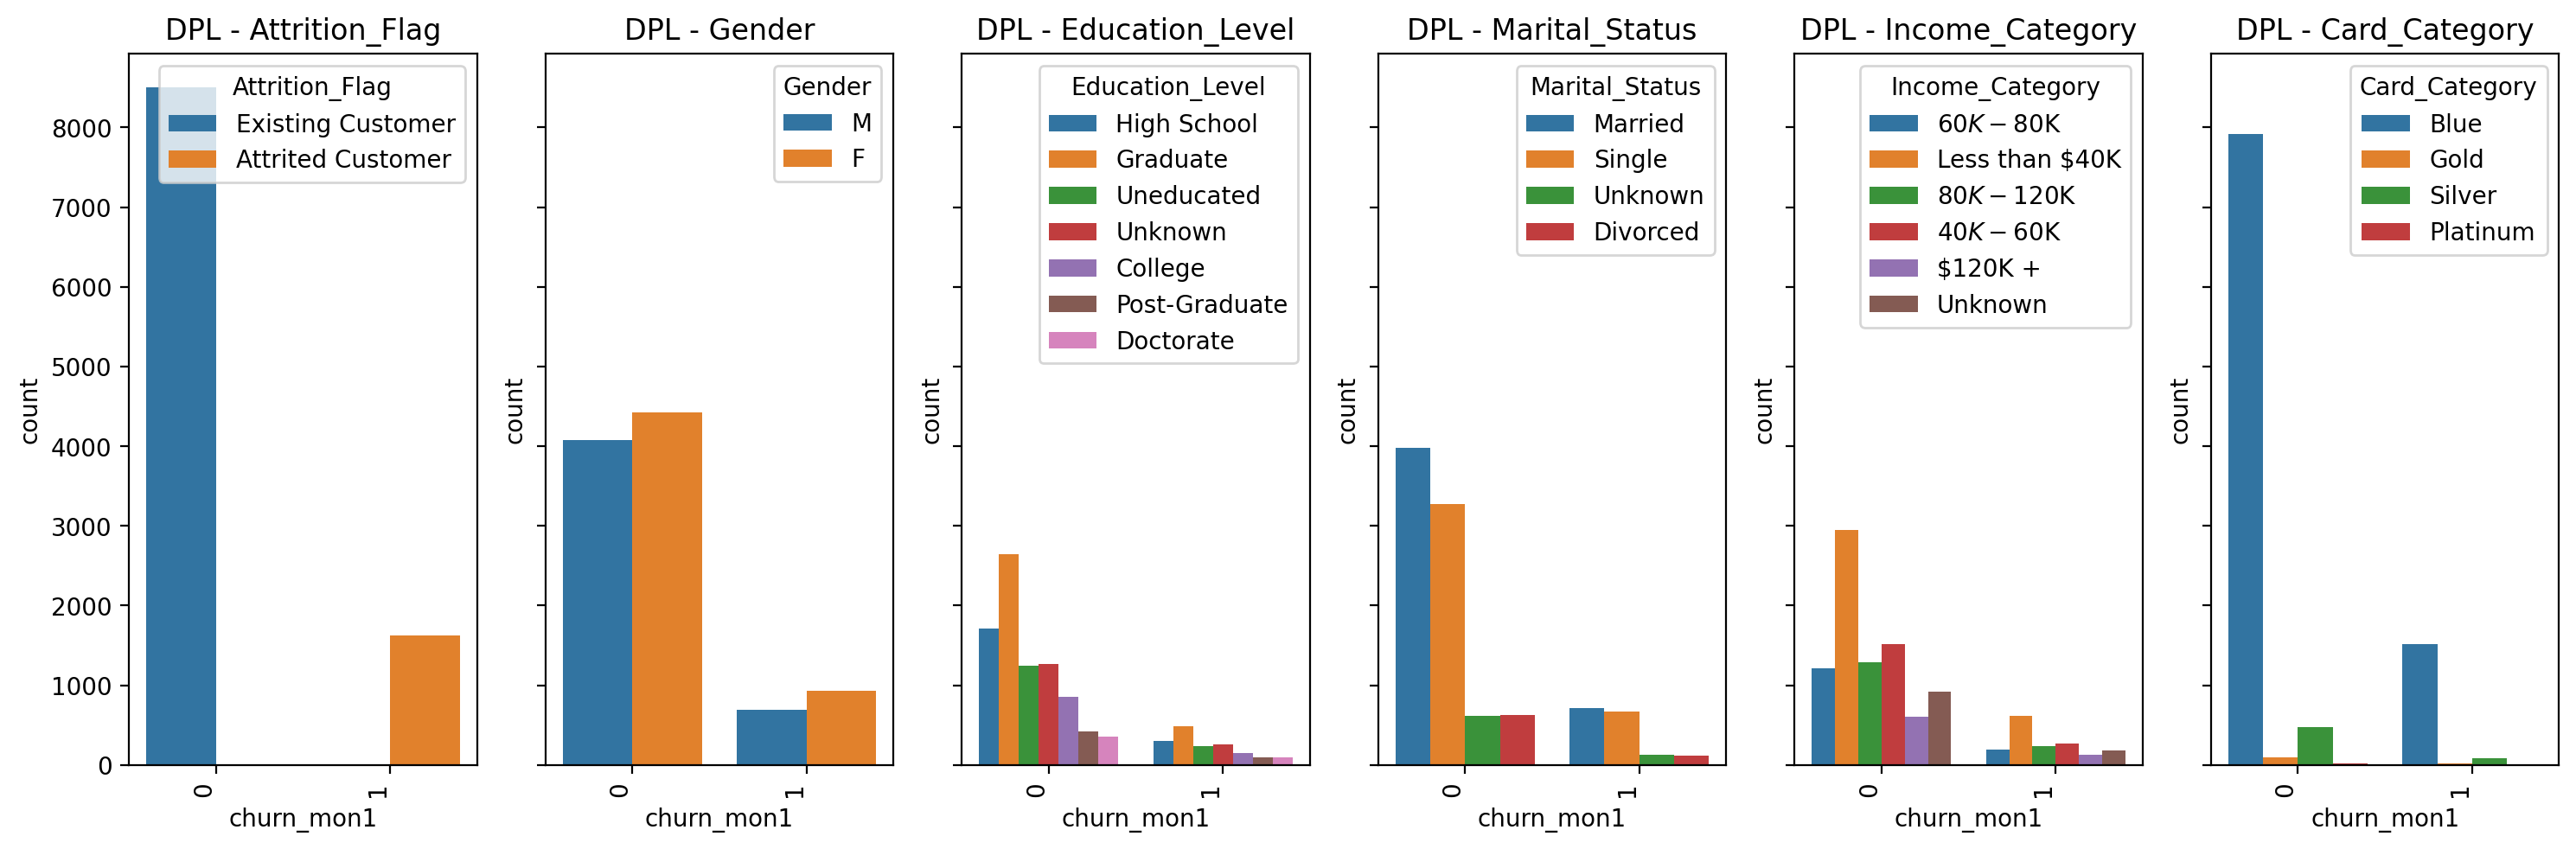

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


# Investigate Class Imbalance
fig, ax = plt.subplots(1, 6, figsize=(15, 5), sharey=True)

for i, cat in enumerate(data.drop(columns = ['churn_mon1']).select_dtypes(['string', 'object']).columns.to_list()):
        sns.countplot(data= data, x=cat, ax=ax[i])
        ax[i].set_title('CI - {}'.format(cat))
        ax[i].set_xticks(ax[i].get_xticks(), ax[i].get_xticklabels(), rotation=90, ha='right')
        plt.tight_layout()

    
# Investigate Difference in Proportion of Labels
fig2, ax2 = plt.subplots(1, 6, figsize=(15, 5), sharey=True)
for j, cat in enumerate(data.drop(columns = ['churn_mon1']).select_dtypes(['string', 'object']).columns.to_list()):
        sns.countplot(data= data, x='churn_mon1', hue=cat, ax=ax2[j])
        ax2[j].set_title('DPL - {}'.format(cat))
        ax2[j].set_xticks(ax2[j].get_xticks(), ax2[j].get_xticklabels(), rotation=90, ha='right')
        plt.tight_layout()
    

# 2. Analyze data bias & explainability with Amazon Sagemaker Clarify
In this section, we analyze bias in `churn_mon1` with respect to the categorical variables, that we take as facets on the dataset.

## 2.1 Configure a `DataConfig`
To run Sagemaker Clarify processing job, we need to have a `DataConfig` that basically tells where to find the raw data, and where to upload the generated report. The label needs to be specified as well. In this notebook we are interested in customers churn, given by `churn_mon1` feature.

In [77]:
from sagemaker.clarify import DataConfig


# Configure data for pre-training bias detection & explainability
raw_data_s3_uri = 's3://{}/data/transformed/BankChurners.csv'.format(bucket)
clarify_report_s3_uri = 's3://{}/data/sagemaker-clarify-report'.format(bucket)
churn_mon1 = target[0]


data_config = DataConfig(
        s3_data_input_path=raw_data_s3_uri,
        s3_output_path=clarify_report_s3_uri,
        label=churn_mon1,
        headers=data.columns.to_list(),
        dataset_type='text/csv', 
)


## 2.2 Configure the BiasConfig
Bias is measured across the categories of interest. These categoies are configured as `facets`.  

To run bias detection, on ore more facets can be included in the analysis along with the positive outcome for the target variable,or a threshold for positive outcome in regression problems. This is configured as `label_values_or_threshold`.

As an additional input, it is possible to limit the bias metrics to one facet value (or to a subset). This approach is not considered in this notebook.  

In [81]:
from sagemaker.clarify import BiasConfig


# Configure pre-training bias detection
label_values = [1]
facets = data.drop(columns=target).select_dtypes(['string','object']).columns.to_list()


bias_config = BiasConfig(
        label_values_or_threshold=label_values, 
        facet_name=facets, 
        facet_values_or_threshold=None, 
        group_name=None
)


print(facets)

['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


## 2.3 Configure Data Explainability
In addition to bias detection, computing feature importance is equally important. It is a key step for data preparation as it reveals the most useful and -on the contrary- uninformative features. 

Explainability with **Amazon Sagemaker Clarify** involves two main techniques that require a model training: `Partial Dependence` and `SHAP`.

In this section, we perform the following steps: 
- Train and deploy a Model to a Sagemaker Endpoint, then use it to configure a `ModelConfig`
- Configure explainability through `Partial Dependence` and `SHAP`

### 2.3.1 Configure the `ModelConfig`
As a first step, we instanciate an `Xgboost` classifier with fixed set of hyperparameters, and then deploy it to a Sagemaker Endpoint. We use the built-in algorithm to keep things simple.

In [82]:
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator


# Configure instance type and distributed processing 
instance_count = 1
instance_type = 'ml.m5.large'


# Configure model training for data explainability
xgboost_image_uri = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")
xgboost_output_path = 's3://{}/data/model/estimator-training-job'.format(bucket)


# Configure hyperparameters
xgboost_hyperparameters = {
        'max_depth': 7,
        'num_round': 300,
        'alpha': 0,
        'gamma': 0,
        'num_class': 2,
        'booster': 'gbtree',
        'early_stopping_rounds': 20,
        'seed': 2023,
        'verbosity': 1
}


# Instanciate Xgboost estimator
xgboost_estimator = Estimator(
        image_uri=xgboost_image_uri,
        role=role,
        instance_count=instance_count,
        instance_type=instance_type,
        output_path=xgboost_output_path,
        sagemaker_session=sess,
        hyperparameters=xgboost_hyperparameters
)


# Configure data channels & train model
xgboost_raw_data_s3_uri = 's3://{}/data/xgboost-training/'.format(bucket)
data_channels = {
        'train': TrainingInput(s3_data=xgboost_raw_data_s3_uri, content_type='text/csv')
}

xgboost_estimator.fit(inputs=data_channels, wait=False)


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-12-12-12-15-49-680


In [104]:
from pprint import pprint

pprint(xgboost_estimator.latest_training_job.describe()['TrainingJobStatus'])

'Completed'


In [105]:
pprint(xgboost_estimator.latest_training_job.describe()['InputDataConfig'])

[{'ChannelName': 'train',
  'CompressionType': 'None',
  'ContentType': 'text/csv',
  'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated',
                                  'S3DataType': 'S3Prefix',
                                  'S3Uri': 's3://sagemaker-eu-west-3-668303144976/data/xgboost-training/'}},
  'RecordWrapperType': 'None'}]


In [106]:
pprint(xgboost_estimator.latest_training_job.describe()['OutputDataConfig'])

{'CompressionType': 'GZIP',
 'KmsKeyId': '',
 'S3OutputPath': 's3://sagemaker-eu-west-3-668303144976/data/model/estimator-training-job'}


Deploy the model to Sagemaker Endpoint.

In [84]:
from datetime import datetime


# Deploy model to sagemaker endpoint
model_name = "clarify-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgboost_estimator.create_model(name=model_name)
container_def = model.prepare_container_def()
sess.create_model(model_name, role, container_def)


INFO:sagemaker:Creating model with name: clarify-model-12-12-2023-12-32-48


'clarify-model-12-12-2023-12-32-48'

Once the model is deployed, we setup a `ModelConfig`, that involves the deployed model, in addition to the compute resources.

The model's input and output formats are given by `content_type`, and `accept_type`, respectively. 

In [85]:
from sagemaker.clarify import ModelConfig


# Configure model for data explainability
model_config = ModelConfig(
        model_name=model_name,
        instance_count=instance_count,
        instance_type=instance_type,
        accept_type='text/csv',
        content_type='text/csv'
)


### 2.3.2 Configure the desired post-training analysis
Data explainability is the second step. We are interested in `PartialDependence` and `SHAP` reports. Both rely on the model trained in the previous section, and  generate reports based on the model's predictions.

We run a simple `SHAPConfig`, in addition to a `PDPConfig`, where we limit the number of desired fetures to `top_k_features=7`.

In [86]:
from sagemaker.clarify import PDPConfig, SHAPConfig


# Configure partial dependence & SHAP analysis
shap_config = SHAPConfig()

partial_dependence_config = PDPConfig(
        features=data.drop(columns = ['churn_mon1']).columns.to_list(),
        top_k_features=7   
)


## 2.4 Configure Amazon SageMaker Clarify as a processing job
Now we need to configure the `SagemakerClarifyProcessor` object, that will allow to launch the bias detection & data explainability processes. Two essential parameters are providd: `instance_count` and `instance_type`. These parameters will define how the process will be scaled. `instance_count` represents how many nodes are desired for the distributed processign, while `instance_type` gives the processing capability in terms of memory and compute capacities.

In this notebook, we will not need extensive compute capabilities, we set
- `instance_count = 1`
- `instance_type = ml.t3.medium`

which will be largely enough for the churn detection use case.

In [88]:
from sagemaker import clarify


# Configure Sagemaker Clarify Processor
clarify_processor = clarify.SageMakerClarifyProcessor(
        role=role,
        instance_count=instance_count,
        instance_type=instance_type,
        sagemaker_session=sess
)


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## 2.5 Run and review the Amazon SageMaker Clarify processing job on the dataset

Bias detection, along with data explainability are initiated using `run_bias_and_explainability` method. It requires the `DataConfig`, `BiasConfig` and `ModelConfig`, `SHAPConfig` and `PDPConfig` previously configured.

In this notebook, we choose to launch full analysis, involving pre-training, post-training bias detection and data explainability using a trained `Xgboost` model. In other cases, the goal may be limited only to pre-training bias metrics. Other methods can be used in that case. Have a look into 
[Sagemaker Clarify Processor Methods](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify) documentation for further information.


In [90]:
# Run bias detection and data explainability
clarify_processor.run_bias_and_explainability(
        data_config=data_config,
        bias_config=bias_config,
        model_config=model_config,
        explainability_config=[shap_config, 
                               partial_dependence_config],
        pre_training_methods='all',
        post_training_methods='all',
        wait=False,
        logs=False
)


INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['churn_mon1', 'CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'], 'label': 'churn_mon1', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'Attrition_Flag'}, {'name_or_index': 'Gender'}, {'name_or_index': 'Education_Level'}, {'name_or_index': 'Marital_Status'}, {'name_or_index': 'Income_Category'}, {'name_or_index': 'Card_Category'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}, 'shap': {'use_logit': False, 'save_local_shap_values': 

In [91]:
# Describe & access reports
run_bias_and_explainability_job_name = clarify_processor.latest_job.job_name
print(run_bias_and_explainability_job_name)


Clarify-Bias-And-Explainability-2023-12-12-12-34-20-023


In [110]:
# Retrieve running processor
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
                                        processing_job_name=run_bias_and_explainability_job_name,
                                        sagemaker_session=sess)

#running_processor.wait(logs=False)
pprint(running_processor.describe())

{'AppSpecification': {'ImageUri': '341593696636.dkr.ecr.eu-west-3.amazonaws.com/sagemaker-clarify-processing:1.0'},
 'CreationTime': datetime.datetime(2023, 12, 12, 12, 34, 20, 210000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 12, 12, 12, 39, 19, 879000, tzinfo=tzlocal()),
 'ProcessingInputs': [{'AppManaged': False,
                       'InputName': 'dataset',
                       'S3Input': {'LocalPath': '/opt/ml/processing/input/data',
                                   'S3CompressionType': 'None',
                                   'S3DataDistributionType': 'FullyReplicated',
                                   'S3DataType': 'S3Prefix',
                                   'S3InputMode': 'File',
                                   'S3Uri': 's3://sagemaker-eu-west-3-668303144976/data/transformed/BankChurners.csv'}},
                      {'AppManaged': False,
                       'InputName': 'analysis_config',
                       'S3Input': {'LocalPath': '

## 2.6 Analyze the bias report

In [ ]:
!aws s3 ls $clarify_report_s3_uri
